In [21]:

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import sys
sys.path.append("/media/cl/Data/2026/Baseline/vlmaps")

from vlmaps.utils.mapping_utils import load_map, get_new_pallete, get_new_mask_pallete
from vlmaps.utils.clip_utils import get_text_feats
from vlmaps.utils.matterport3d_categories import mp3dcat
import clip



"""一、加载路径"""
root_dir='/media/cl/Data/2026/Baseline/vlmaps/vlmaps_dataset'
data_dir = os.path.join(root_dir,  "FloorPlan13_2") #5LpN3gDmAk7_1
data_dir = data_dir # @param {type: "string"}


map_save_dir = os.path.join(data_dir, "map")
os.makedirs(map_save_dir, exist_ok=True)

color_top_down_save_path = os.path.join(map_save_dir, f"color_top_down_1.npy")
grid_save_path = os.path.join(map_save_dir, f"grid_lseg_1.npy")
obstacles_save_path = os.path.join(map_save_dir, "obstacles.npy")



[0 1]


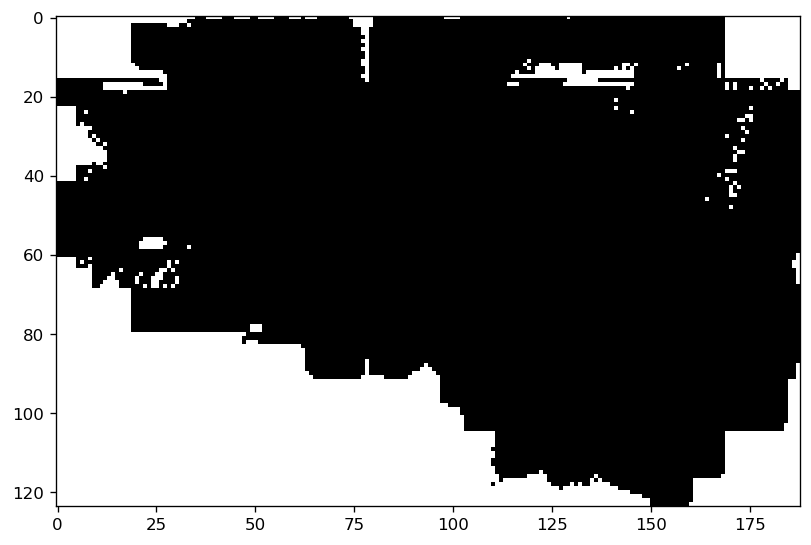

In [22]:
"""二、绘制占有地图，generate_obstacle_map.py也可以绘制地图 后续检测"""

obstacles = load_map(obstacles_save_path)
x_indices, y_indices = np.where(obstacles == 0)

xmin = np.min(x_indices)
xmax = np.max(x_indices)
ymin = np.min(y_indices)
ymax = np.max(y_indices)

print(np.unique(obstacles))
obstacles_pil = Image.fromarray(obstacles[xmin:xmax+1, ymin:ymax+1])
plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(obstacles_pil, cmap='gray')
plt.show()

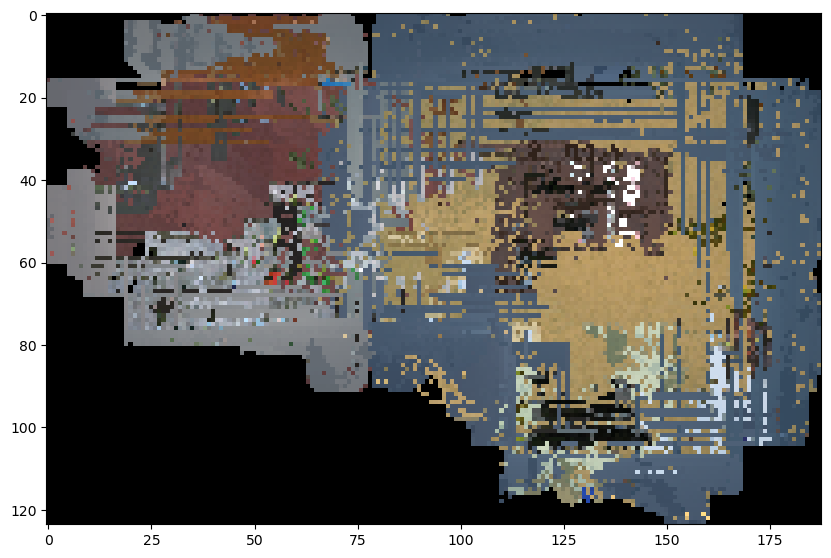

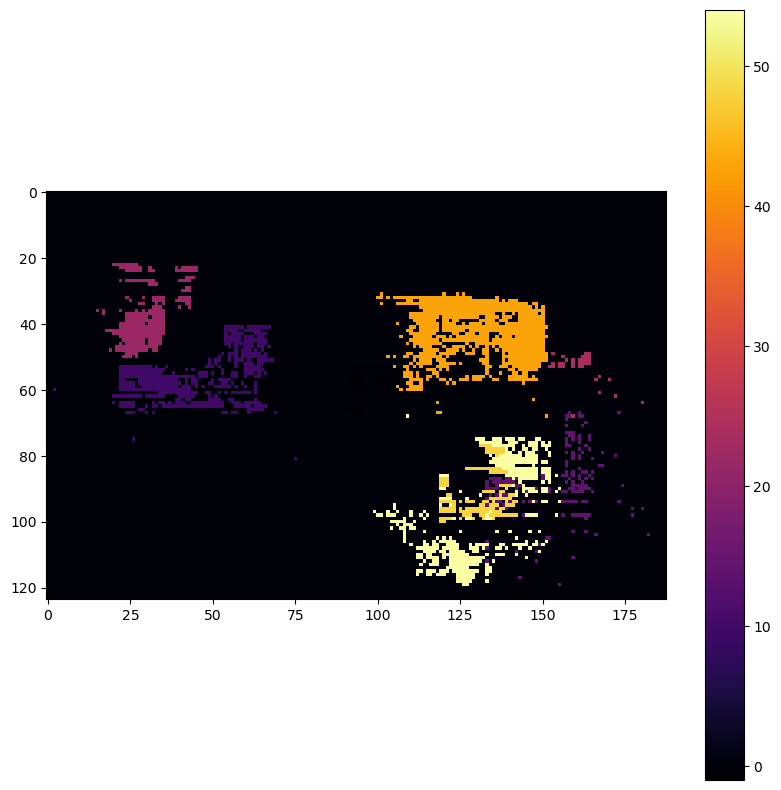

In [23]:
"""二、绘制RGB俯视图地图"""
import matplotlib.cm as cm
color_top_down = load_map(color_top_down_save_path)
color_top_down = color_top_down[xmin:xmax+1, ymin:ymax+1]
color_top_down_pil = Image.fromarray(color_top_down)
plt.figure(figsize=(10, 15), dpi=100)
plt.imshow(color_top_down_pil)
plt.show()


## 通过 语义图 得到的真实俯视图地图
color_top_down = load_map(os.path.join(map_save_dir, f"grid_1_gt.npy"))
color_top_down = color_top_down[xmin:xmax+1, ymin:ymax+1]
# color_top_down_pil = Image.fromarray(color_top_down)
plt.figure(figsize=(10, 10), dpi=100)
colormap = cm.inferno  # 或者使用任何其他的 colormap 比如 'Blues', 'Reds', 'inferno', 等等

plt.imshow(color_top_down,cmap=colormap, interpolation='nearest')
plt.colorbar()
plt.show()

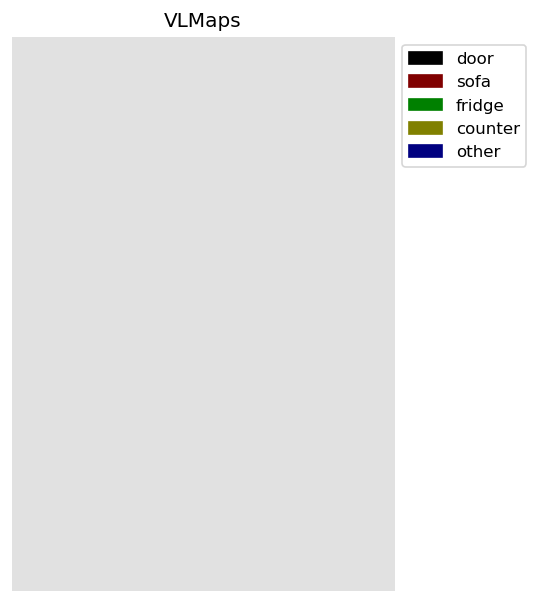

In [102]:
"""三、绘制开放式自然语言的地标地图"""

import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_version = "ViT-B/32"
clip_feat_dim = {'RN50': 1024, 'RN101': 512, 'RN50x4': 640, 'RN50x16': 768,
                'RN50x64': 1024, 'ViT-B/32': 512, 'ViT-B/16': 512, 'ViT-L/14': 768}[clip_version]
clip_model, preprocess = clip.load(name='/media/cl/SSK/OtherCode/vlmaps_ai2thor/model/clip/ViT-B-32.pt')  # clip.available_models()
clip_model.to(device).eval()

grid = load_map(grid_save_path)
grid = grid[xmin:xmax+1, ymin:ymax+1]

lang = "door,sofa,fridge,counter,other"# @param {type: "string"} 似乎要和前面的语言保持一致
lang = lang.split(",")
text_feats = get_text_feats(lang, clip_model, clip_feat_dim)
no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0
map_feats = grid.reshape((-1, grid.shape[-1]))
scores_list = map_feats @ text_feats.T

predicts = np.argmax(scores_list, axis=1)
predicts = predicts.reshape((xmax - xmin + 1, ymax - ymin + 1))
floor_mask = predicts == 2

new_pallete = get_new_pallete(len(lang))
mask, patches = get_new_mask_pallete(predicts, new_pallete, out_label_flag=True, labels=lang)
seg = mask.convert("RGBA")
seg = np.array(seg)
seg[no_map_mask] = [225, 225, 225, 255]
seg[floor_mask] = [225, 225, 225, 255]
seg = Image.fromarray(seg)
plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.show()

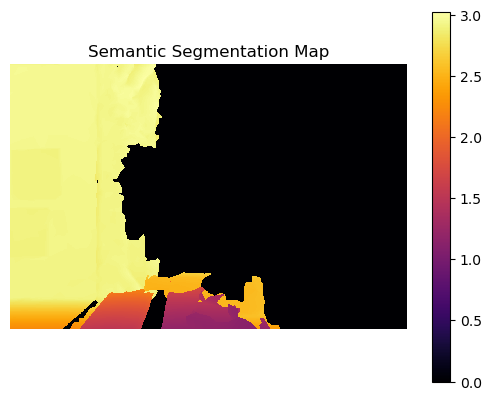

In [101]:
## 可视化 一个后缀名为.npy的语义分隔图
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# 1. 加载 .npy 文件
semantic = np.load('/media/cl/Data/2026/Baseline/vlmaps/vlmaps_dataset/5LpN3gDmAk7_1/depth/5LpN3gDmAk7_1.npy')  # 加载语义分隔图，假设它是一个二维数组

# 2. 定义颜色映射
# 这里使用了`plt.cm.Greens`作为示例，你可以根据需求选择其他色图（colormap）
# `Greens` 色图的颜色从浅绿色到深绿色
colormap = cm.inferno  # 或者使用任何其他的 colormap 比如 'Blues', 'Reds', 'inferno', 等等

# 3. 可视化语义图
plt.imshow(semantic, cmap=colormap, interpolation='nearest')

# 4. 添加颜色条（显示数值范围）
plt.colorbar()

# 5. 显示图像
plt.title("Semantic Segmentation Map")
plt.axis('off')  # 关闭坐标轴
plt.show()



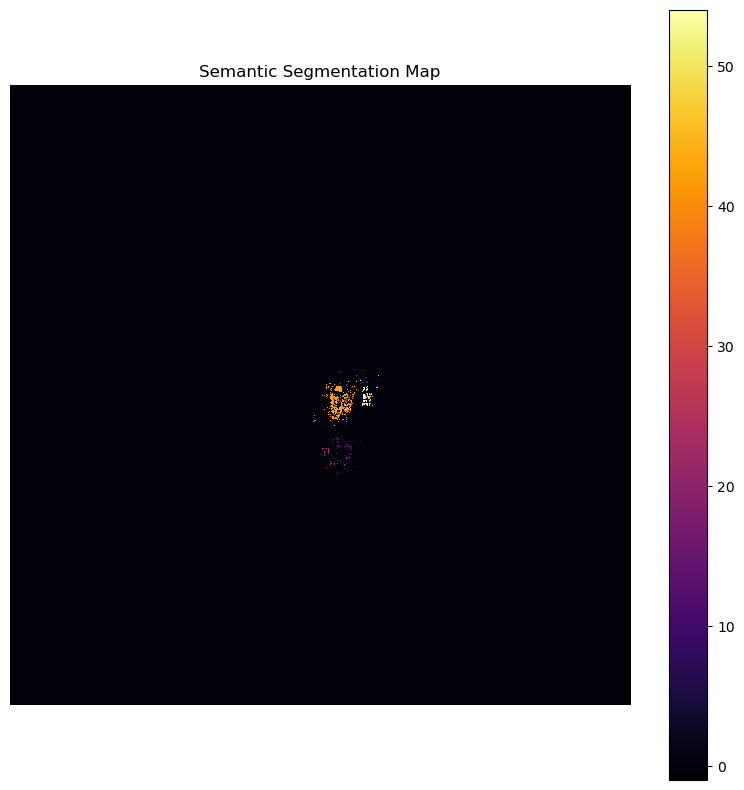

In [37]:


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# 1. 加载 .npy 文件
semantic = np.load(os.path.join(map_save_dir, f"grid_1_gt.npy"))  # 加载语义分隔图，假设它是一个二维数组
plt.figure(figsize=(10, 10), dpi=100)
# '/media/cl/Data/2026/Baseline/vlmaps/vlmaps_dataset/FloorPlan13_1/semantic/FloorPlan13_19.npy'
# 2. 定义颜色映射
# 这里使用了`plt.cm.Greens`作为示例，你可以根据需求选择其他色图（colormap）
# `Greens` 色图的颜色从浅绿色到深绿色
colormap = cm.inferno  # 或者使用任何其他的 colormap 比如 'Blues', 'Reds', 'inferno', 等等

# 3. 可视化语义图
plt.imshow(semantic, cmap=colormap, interpolation='nearest')

# 4. 添加颜色条（显示数值范围）
plt.colorbar()

# 5. 显示图像
plt.title("Semantic Segmentation Map")
plt.axis('off')  # 关闭坐标轴
plt.show()